In [29]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
import json
from collections import defaultdict
from typing import Tuple, Dict, Union, List

# import preprocess
# print([name for name in dir(preprocess) if not name.startswith("_")])

Load Data

In [31]:
def load(paths: list[str]) -> pd.DataFrame:
  dfs = [pd.read_csv(path) for path in paths] 
  df = pd.concat(dfs, ignore_index=True) 
  df["tourney_date"] = pd.to_datetime(df['tourney_date'], format='%Y%m%d')
  return df

start_year = 1968
end_year = 2024
fut_start_year = 1991
fut_end_year = 2024
chl_start_year = 1978
chl_end_year = 2024
paths = []
    # paths.append(f"../data/atp_matches_2023.csv")
for year in range(start_year, end_year + 1):
    paths.append(f"../data/atp_matches_{year}.csv")

for year in range(fut_start_year, fut_end_year + 1):
    paths.append(f"../data/atp_matches_futures_{year}.csv")     

for year in range(chl_start_year, chl_end_year + 1):
    paths.append(f"../data/atp_matches_qual_chall_{year}.csv")      

df = load(paths)

Preprocess Stage 1: add elos

In [32]:
def sort_chronologically(df: pd.DataFrame) -> pd.DataFrame:
  return df.sort_values(['tourney_date', 'match_num', 'tourney_id']).reset_index(drop=True)

def calc_and_update_ratings(ratings: Dict, winner_id: int, loser_id: int, winner_elo: List[float], loser_elo: List[float], update: bool, k: int = 32) -> None:
  ra = ratings[winner_id]
  rb = ratings[loser_id]
  winner_elo.append(ra)
  loser_elo.append(rb)
  if update:
    ea = 1 / (1 + 10 ** ((rb - ra) / 400))
    ratings[winner_id] += k * (1 - ea)
    ratings[loser_id] += k * (ea - 1)

def add_elos(df: pd.DataFrame, k: int = 32, initial_rating: int = 1500) -> Tuple[pd.DataFrame, Dict[int, float], Dict[int, float], Dict[int, float], Dict[int, float], Dict[int, float]]:
  df = sort_chronologically(df)
  ratings = defaultdict(lambda: initial_rating)

  eloWinner = []
  eloLoser = []

  hard_ratings = defaultdict(lambda: initial_rating)
  clay_ratings = defaultdict(lambda: initial_rating)
  grass_ratings = defaultdict(lambda: initial_rating)
  carpet_ratings = defaultdict(lambda: initial_rating)

  hardEloWinner = []
  clayEloWinner = []
  grassEloWinner = []
  carpetEloWinner = []
  hardEloLoser = []
  clayEloLoser = []
  grassEloLoser = []
  carpetEloLoser = []

  surface_map = {
    "Hard":   (hard_ratings,   hardEloWinner,   hardEloLoser),
    "Clay":   (clay_ratings,   clayEloWinner,   clayEloLoser),
    "Grass":  (grass_ratings,  grassEloWinner,  grassEloLoser),
    "Carpet": (carpet_ratings, carpetEloWinner, carpetEloLoser),
  }

  for row in df.itertuples(index=False):
    calc_and_update_ratings(ratings, row.winner_id, row.loser_id, eloWinner, eloLoser, update=True)

    for surf, (surf_ratings, eloW, eloL) in surface_map.items():
      should_update = (row.surface == surf)
      calc_and_update_ratings(surf_ratings, row.winner_id, row.loser_id, eloW, eloL, update=should_update)

  df["winner_elo"] = eloWinner
  df["loser_elo"] = eloLoser
  df["winner_hard_elo"] = hardEloWinner
  df["loser_hard_elo"] = hardEloLoser
  df["winner_clay_elo"] = clayEloWinner
  df["loser_clay_elo"] = clayEloLoser
  df["winner_grass_elo"] = grassEloWinner
  df["loser_grass_elo"] = grassEloLoser
  df["winner_carpet_elo"] = carpetEloWinner
  df["loser_carpet_elo"] = carpetEloLoser

  # df_djok = df[df['winner_name'] == 'Novak Djokovic']
  # df_fed = df[df['winner_name'] == 'Roger Federer']
  # df_nad = df[df['winner_name'] == 'Rafael Nadal']
  # df_alc = df[df['winner_name'] == 'Carlos Alcaraz']
  # df_sin = df[df['winner_name'] == 'Jannik Sinner']

  # df_djok = df_djok.sort_values('tourney_date')
  # df_fed  = df_fed.sort_values('tourney_date')
  # df_nad  = df_nad.sort_values('tourney_date')
  # df_alc  = df_alc.sort_values('tourney_date')
  # df_sin  = df_sin.sort_values('tourney_date')

  # # Create the plot
  # plt.figure(figsize=(12, 6))

  # plt.plot(df_djok['tourney_date'], df_djok['winner_hard_elo'], marker='o', linestyle='-', label='Djokovic')
  # plt.plot(df_fed['tourney_date'],  df_fed['winner_hard_elo'],  marker='s', linestyle='--', label='Federer')
  # plt.plot(df_nad['tourney_date'],  df_nad['winner_hard_elo'],  marker='^', linestyle='-.', label='Nadal')
  # plt.plot(df_alc['tourney_date'],  df_alc['winner_hard_elo'],  marker='^', linestyle='-.', label='Alcaraz')
  # plt.plot(df_sin['tourney_date'],  df_sin['winner_hard_elo'],  marker='^', linestyle='-.', label='Sinner')

  # plt.title('Winner ELO over Time')
  # plt.xlabel('Date')
  # plt.ylabel('Winner ELO')
  # plt.xticks(rotation=45)
  # plt.legend()
  # plt.tight_layout()
  # plt.show()



  return df, ratings, hard_ratings, clay_ratings, grass_ratings, carpet_ratings



df, ratings, hard_ratings, clay_ratings, grass_ratings, carpet_ratings = add_elos(df)
  # print(df.shape)
with open('elos.json', 'w') as f:
    json.dump(ratings, f)
with open('hard_elos.json', 'w') as f:
    json.dump(hard_ratings, f)
with open('clay_elos.json', 'w') as f:
    json.dump(clay_ratings, f)
with open('grass_elos.json', 'w') as f:
    json.dump(grass_ratings, f)
with open('carpet_elos.json', 'w') as f:
    json.dump(carpet_ratings, f)

Preprocess stage 2: add recent form (win rate over last 10 matches)

In [33]:
def add_recent_form(df: pd.DataFrame, window: int = 10):
  date_col = "tourney_date"
  df_w = df.loc[:, ["tourney_id", date_col, "match_num", "winner_id"]].copy()
  df_l = df.loc[:, ["tourney_id", date_col, "match_num", "loser_id"].copy()]
  df_w["player_id"] = df_w["winner_id"]
  df_l["player_id"] = df_l["loser_id"]
  df_w["outcome"] = 1
  df_l["outcome"] = 0
# need to fix the sort by date
  cdf = pd.concat([df_w, df_l], ignore_index=True)
  cdf = sort_chronologically(cdf)

  cdf["form"] = (cdf.groupby("player_id")["outcome"].transform(lambda s: s.shift().rolling(window, min_periods=1).mean()))
  winner_form = cdf.loc[cdf["outcome"] == 1, ["tourney_id", "match_num", "player_id", "form"]]
  winner_form.columns = ["tourney_id", "match_num", "winner_id","winner_form"]
  loser_form = cdf.loc[cdf["outcome"] == 0, ["tourney_id", "match_num", "player_id", "form"]]
  loser_form.columns = ["tourney_id", "match_num", "loser_id", "loser_form"]

  df = df.merge(winner_form, on=["tourney_id", "match_num", "winner_id"], how="left")
  df = df.merge(loser_form, on=["tourney_id", "match_num", "loser_id"], how="left")
  return df

df = add_recent_form(df)

Preprocess Stage 3: Calc H2H between opponents

In [36]:
def add_head_to_head(df: pd.DataFrame) -> Tuple[pd.DataFrame, Dict[Tuple[int, int], Dict]]:
  date_col = "tourney_date"
  df = df.copy()
  df = sort_chronologically(df)

  h2h = defaultdict(lambda: {'A': 0, 'B': 0})

  wins_A_list = []
  wins_B_list = []

  for _, row in df.iterrows():
    a = row["winner_id"]
    b = row["loser_id"]
    wins_A = h2h[(a, b)]["A"]
    wins_B = h2h[(a, b)]["B"]
    wins_A_list.append(wins_A)
    wins_B_list.append(wins_B)
    h2h[(a, b)]["A"] += 1
    h2h[(b, a)]["B"] += 1
  
  df["winner_wins"] = wins_A_list
  df["loser_wins"] = wins_B_list
  df["total_matches"] = df["winner_wins"] + df["loser_wins"]

  return df, h2h


df, h2h = add_head_to_head(df)
h2h_serializable = {
    f"{winner},{loser}": counts
    for (winner, loser), counts in h2h.items()
}
with open('h2h.json','w') as f:
    json.dump(h2h_serializable, f)

Preprocess Stage 4: Compute stats for players over last 10 matches

In [37]:
def compute_agg_stat(df: pd.DataFrame, col: str, window: int) -> pd.DataFrame:
  df = sort_chronologically(df)

  col_w = (
    df[['tourney_date', 'match_num', 'tourney_id', 'winner_id',f"w_{col}"]]
      .rename(columns={'winner_id':'player_id',f"w_{col}":col})
      .reset_index()
      .rename(columns={'index':'orig_idx'})
  )
  col_w['role'] = 'w'
  col_l = (
    df[['tourney_date', 'match_num', 'tourney_id', 'winner_id',f"l_{col}"]]
      .rename(columns={'winner_id':'player_id',f"l_{col}":col})
      .reset_index()
      .rename(columns={'index':'orig_idx'})
  )
  col_l['role'] = 'l'

  col_all = pd.concat([col_w, col_l], ignore_index=True)
  col_all = col_all.sort_values(['player_id','tourney_date', 'match_num', 'tourney_id'])

  col_all[f'{col}_window'] = (
    col_all
      .groupby('player_id')[col]
      .rolling(window=window, min_periods=1)
      .sum()
      .shift(1)             # don't include current match  
      .reset_index(level=0, drop=True)
  )

  w_feats = (
      col_all[col_all['role']=='w']
        .loc[:, ['orig_idx',f'{col}_window']]
        .set_index('orig_idx')
        .rename(columns={f'{col}_window':f'w_{col}_window'})
  )

  l_feats = (
      col_all[col_all['role']=='l']
        .loc[:, ['orig_idx',f'{col}_window']]
        .set_index('orig_idx')
        .rename(columns={f'{col}_window':f'l_{col}_window'})
  )

  df = df.reset_index(drop=True)
  df[f'w_{col}_window'] = w_feats[f'w_{col}_window']
  df[f'l_{col}_window'] = l_feats[f'l_{col}_window']
  return df






def compute_agg_stats(df: pd.DataFrame, window: int = 10) -> pd.DataFrame:
  df = compute_agg_stat(df, "ace", window)
  df = compute_agg_stat(df, "df", window)
  df = compute_agg_stat(df, "svpt", window)
  df = compute_agg_stat(df, "1stIn", window)
  df = compute_agg_stat(df, "1stWon", window)
  df = compute_agg_stat(df, "2ndWon", window)
  df = compute_agg_stat(df, "SvGms", window)
  df = compute_agg_stat(df, "bpSaved", window)
  df = compute_agg_stat(df, "bpFaced", window)
  return df

  


df = compute_agg_stats(df)

Preprocess Stage 5: Turn winner & loser into playerA and playerB. Add diff-related cols

In [41]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
  # 0 is right, 1 is left
  df["winner_left_hand"] = (df.loc[:, "winner_hand"] == 'L')
  df["loser_left_hand"] = (df.loc[:, "loser_hand" ] == 'L')

  winner_cols = [c for c in df.columns if c.startswith("winner_")]
  w_cols = [c for c in df.columns if c.startswith("w_")]
  loser_cols = [c for c in df.columns if c.startswith("loser_")]
  l_cols = [c for c in df.columns if c.startswith("l_")]
  other_cols = [c for c in df.columns if c not in winner_cols + w_cols + loser_cols + l_cols]

  df_A = df[winner_cols + w_cols + other_cols].copy()
  df_A.columns = [c.replace("winner_", "playerA_") for c in winner_cols] + [c.replace("w_", "playerA_") for c in w_cols] + other_cols
  # 0 if playerA is the winner, 1 if playerB is the winner
  df_A["outcome"] = 0
  for c in loser_cols:
    df_A[c.replace("loser_", "playerB_")] = df[c].values
  for c in l_cols:
    df_A[c.replace("l_", "playerB_")] = df[c].values
  
  df_B = df[loser_cols + l_cols + other_cols].copy()
  df_B.columns = [c.replace("loser_", "playerA_") for c in loser_cols]+ [c.replace("l_", "playerA_") for c in l_cols] + other_cols
  df_B["outcome"] = 1
  for c in winner_cols:
    df_B[c.replace("winner_", "playerB_")] = df[c].values
  for c in w_cols:
    df_B[c.replace("w_", "playerB_")] = df[c].values

  df_model = pd.concat([df_A, df_B], ignore_index=True)
  df_model = df_model.sample(frac=1, random_state=42).reset_index(drop=True) # shuffle

  df_model["match_key"] = df_model.apply(
    lambda r: (
        min(r.playerA_id, r.playerB_id),
        max(r.playerA_id, r.playerB_id),
        r.tourney_id, r.match_num  # or whatever date field you have
    ),
    axis=1
  )

  df_model = df_model.drop_duplicates(subset="match_key", keep="first").reset_index(drop=True)

  df_model["age_diff"] = df_model["playerA_age"] - df_model["playerB_age"]
  df_model["height_diff"] = df_model["playerA_ht"] - df_model["playerB_ht"]
  df_model["elo_diff"] = df_model["playerA_elo"] - df_model["playerB_elo"]
  df_model["hard_elo_diff"] = df_model["playerA_hard_elo"] - df_model["playerB_hard_elo"]
  df_model["clay_elo_diff"] = df_model["playerA_clay_elo"] - df_model["playerB_clay_elo"]
  df_model["grass_elo_diff"] = df_model["playerA_grass_elo"] - df_model["playerB_grass_elo"]
  df_model["carpet_elo_diff"] = df_model["playerA_carpet_elo"] - df_model["playerB_carpet_elo"]
  df_model["rank_diff"] = df_model["playerA_rank"] - df_model["playerB_rank"]
  df_model["form_diff"] = df_model["playerA_form"] - df_model["playerB_form"]
  df_model["surface"] = df_model["surface"].astype("category")
  df_model["h2h_diff"] = df_model["playerA_wins"] - df_model["playerB_wins"]
  df_model["tourney_level"] = df_model["tourney_level"].astype("category")
  df_model["playerA_ioc"] = df_model["playerA_ioc"].astype("category")
  df_model["playerB_ioc"] = df_model["playerA_ioc"].astype("category")
  df_model["round"] = df_model["round"].astype("category")
  df_model["playerA_entry"] = df_model["playerA_entry"].astype("category")
  df_model["playerB_entry"] = df_model["playerB_entry"].astype("category")
  df_model["five_setter"] = df_model["best_of"] == 5



  return df_model

df = preprocess(df)



Define input & obj

In [42]:
# df["y_reg"] = np.where(df["outcome"] == 1, 1.0, 0.0)
predict_cols = ["elo_diff", "hard_elo_diff", "clay_elo_diff", "grass_elo_diff", "carpet_elo_diff", "form_diff", "rank_diff", "h2h_diff", "total_matches", 
'surface', 'tourney_level', 'five_setter',  "playerA_left_hand", "playerB_left_hand", "age_diff", "height_diff", "playerA_ace_window", 
"playerB_ace_window", 'playerB_df_window', 'playerA_svpt_window','playerB_svpt_window', 'playerA_1stIn_window', 'playerB_1stIn_window', 'playerA_1stWon_window', 'playerB_1stWon_window', 
'playerA_2ndWon_window', 'playerB_2ndWon_window', 'playerA_SvGms_window', 'playerB_SvGms_window', 'playerA_bpSaved_window', 'playerB_bpSaved_window', 'playerA_bpFaced_window', 'playerB_bpFaced_window']
X = df[predict_cols] 
y = df["outcome"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Train model

In [43]:
model = XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42, 
        enable_categorical=True
)
model.fit(X_train, y_train)
model.save_model("tennis_xgb.json")

Evaluate

Test Accuracy: 0.706
Classification Error: 0.294


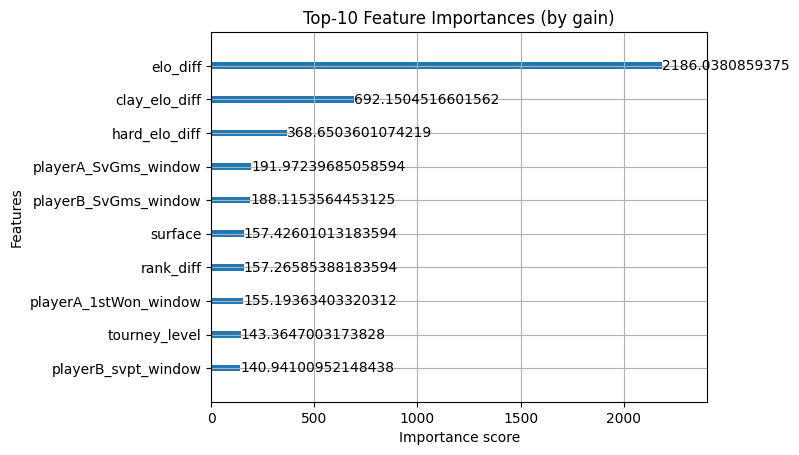

In [44]:
y_pred_label = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_label)
classification_error = 1 - accuracy
print(f"Test Accuracy: {accuracy:.3f}")
print(f"Classification Error: {classification_error:.3f}")

importance_dict = model.get_booster().get_score(importance_type='gain')
plot_importance(importance_dict, importance_type='gain', max_num_features=10)
plt.title("Top‑10 Feature Importances (by gain)")
plt.show()